## Imports

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,738 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

### Import Packages

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

import pandas_datareader.naver as web_naver

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
idx = pd.IndexSlice
sns.set(font='NanumBarunGothic',
       rc={'axes.unicode_minus':False},
       style='darkgrid')
plt.rc('font', family='NanumBarunGothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
sns.set_style('whitegrid')
np.random.seed(42)

### Import data

In [4]:
krx100 = pd.read_csv('KRX100.csv', encoding='cp949')
krx100.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,373220,LG에너지솔루션,400000,500,0.13,93600000.0
2,660,SK하이닉스,98700,4700,5.00,71853833.0
3,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
4,5380,현대차,183500,1000,0.55,39208112.0


In [5]:
krx300 = pd.read_csv('KRX300.csv', encoding='cp949')
krx300.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,660,SK하이닉스,98700,4700,5.00,71853833.0
2,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
3,5380,현대차,183500,1000,0.55,39208112.0
4,35420,NAVER,231000,-2500,-1.07,37895339.0


In [6]:
kospi200 = pd.read_csv('KOSPI200.csv', encoding='cp949')
kospi200.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,5930,삼성전자,60000,2500,4.35,358186953.0
1,373220,LG에너지솔루션,400000,500,0.13,93600000.0
2,660,SK하이닉스,98700,4700,5.00,71853833.0
3,207940,삼성바이오로직스,817000,-8000,-0.97,58149158.0
4,5380,현대차,183500,1000,0.55,39208112.0


In [7]:
kosdaq150 = pd.read_csv('KOSDAQ150.csv', encoding='cp949')
kosdaq150.head()

,종목코드,종목명,종가,대비,등락률,상장시가총액
0,91990,셀트리온헬스케어,70500,-800,-1.12,11149919.0
1,247540,에코프로비엠,111500,-5500,-4.70,10904850.0
2,66970,엘앤에프,207500,-5500,-2.58,7455395.0
3,28300,HLB,42800,250,0.59,4574581.0
4,293490,카카오게임즈,49400,-2100,-4.08,3887740.0


In [8]:
start = datetime.datetime(2012,1,1)
end = datetime.datetime(2021,1,1)
#dataset = pd.concat([kospi200, kosdaq150], axis=0)
#dataset = krx100
dataset = krx300

In [9]:
def import_price_data(start, end, dataset):
    dictionary = {}
    code_list = dataset['종목코드'].tolist()
    name_list = dataset['종목명'].tolist()
    for i in range(len(code_list)):
        code = str(code_list[i]).zfill(6)
        name = name_list[i]
        df = web_naver.NaverDailyReader(symbols=code, start=start, end=end, adjust_price=True).read()
        adj_close = df.Close
        dictionary[name] = adj_close
    data = pd.DataFrame(dictionary)
    data = data.astype('float')
    return data

In [10]:
df = import_price_data(start, end, dataset)

In [11]:
# 5% 이상의 결측치가 존재하면 그 종목은 사용하지 않기로 한다.
def dropna_percent(percentage, dataset):
    print('결측치 존재 여부: ', dataset.isnull().values.any())
    missing_fraction = dataset.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fraction[missing_fraction > percentage].index))
    new_df = dataset.drop(labels=drop_list, axis=1)
    print(f"제거한 column의 수는 {len(drop_list)}개 입니다.")
    return new_df

In [12]:
df = dropna_percent(0.05, df)

결측치 존재 여부:  True
제거한 column의 수는 93개 입니다.


In [13]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
print(df.shape)
print('결측치 존재 여부: ', df.isnull().values.any())

(2215, 207)
결측치 존재 여부:  False


In [14]:
train = df[df.index < '2019-01-01']
test = df[df.index > '2019-01-01']

## Finding pair

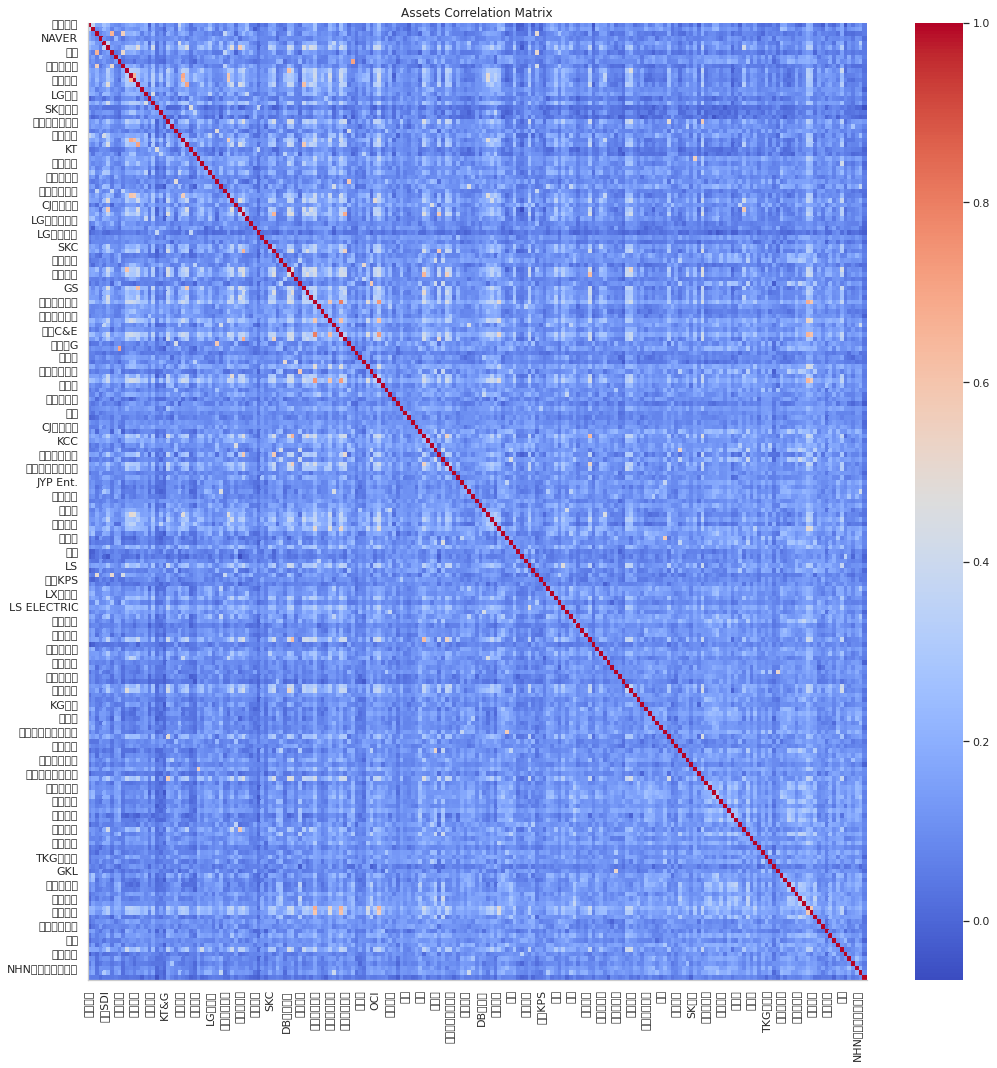

In [15]:
# Spearman correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train.pct_change().corr(method ='spearman'),ax=ax, cmap='coolwarm')
ax.set_title('Assets Correlation Matrix')
sns.despine()
plt.tight_layout()

In [16]:
def find_cointegrated_pairs(data, p_value):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < p_value:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [17]:
pvalues, pairs = find_cointegrated_pairs(train, 0.01)
print("페어의 개수: ", len(pairs))
print(pairs)

100%|██████████| 207/207 [35:00<00:00, 10.15s/it]

페어의 개수:  392
[('삼성전자', 'KB금융'), ('삼성전자', '현대해상'), ('삼성전자', '후성'), ('삼성전자', '에스에프에이'), ('현대차', '삼성중공업'), ('현대차', '대우조선해양'), ('현대차', '포스코인터내셔널'), ('현대차', 'DGB금융지주'), ('현대차', '현대바이오'), ('현대차', '메디톡스'), ('현대차', '부광약품'), ('현대차', '아난티'), ('삼성SDI', '동양생명'), ('LG화학', 'S-Oil'), ('카카오', '기업은행'), ('셀트리온', 'HLB'), ('셀트리온', '대웅제약'), ('셀트리온', '신풍제약'), ('셀트리온', 'HLB생명과학'), ('현대모비스', 'SK'), ('현대모비스', 'SK텔레콤'), ('현대모비스', '두산에너빌리티'), ('현대모비스', 'LG생활건강'), ('현대모비스', '삼성화재'), ('현대모비스', '한국조선해양'), ('현대모비스', 'LG유플러스'), ('현대모비스', '삼성중공업'), ('현대모비스', 'HLB'), ('현대모비스', '한국금융지주'), ('현대모비스', '쌍용C&E'), ('현대모비스', '메리츠금융지주'), ('현대모비스', '메리츠증권'), ('현대모비스', 'OCI'), ('현대모비스', '롯데쇼핑'), ('현대모비스', '한솔케미칼'), ('현대모비스', '에스원'), ('현대모비스', '한전기술'), ('현대모비스', '대우조선해양'), ('현대모비스', '대웅제약'), ('현대모비스', '대우건설'), ('현대모비스', '포스코인터내셔널'), ('현대모비스', '한화에어로스페이스'), ('현대모비스', '리노공업'), ('현대모비스', '대웅'), ('현대모비스', 'LS'), ('현대모비스', '오뚜기'), ('현대모비스', '휠라홀딩스'), ('현대모비스', 'DGB금융지주'), ('현대모비스', '동화기업'), ('현대모비스', '현대바이오'), ('현대모비스', 'HLB생명과학'), ('현

## Perform EDA and Cointegration test for Selected pair

### Choose one pair

In [18]:
asset1 = '삼성전자'
asset2 = 'KB금융'

In [19]:
pair1 = pd.DataFrame()
pair1[asset1] = train[asset1]
pair1[asset2] = train[asset2]

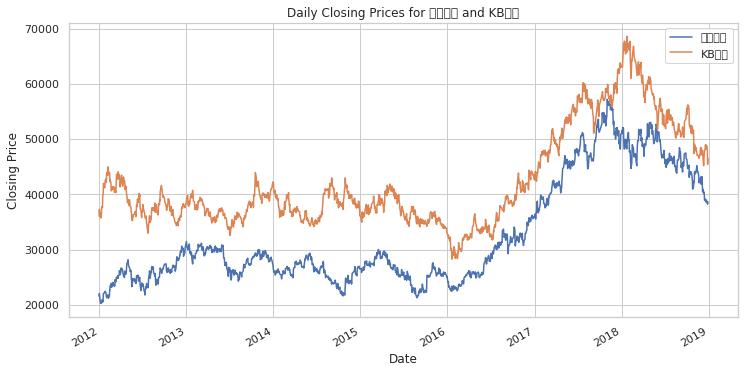

In [20]:
# 두 자산의 움직임을 시각화
ax = pair1[[asset1, asset2]].plot(figsize=(12, 6))
ax.set_title('Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True)

### Calculate spread and ratio

In [21]:
# run OLS regression
model=sm.OLS(pair1.삼성전자, pair1.KB금융).fit()

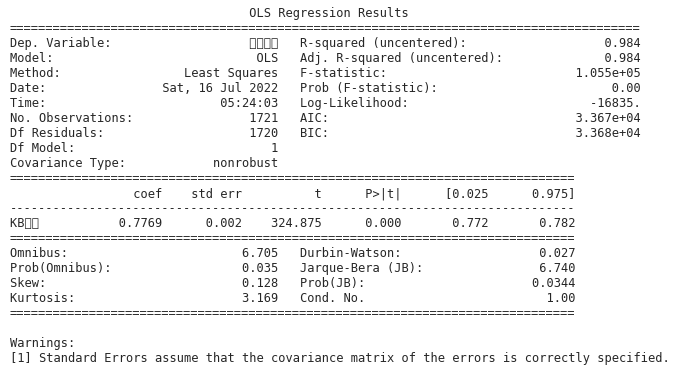

In [22]:
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)

In [23]:
# calculate spread
spread = pair1.삼성전자 - model.params[0] * pair1.KB금융

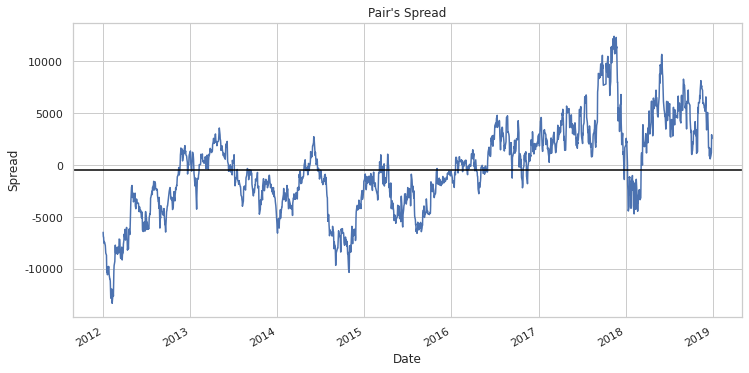

In [24]:
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.axhline(spread.mean(), color='black')
ax.set_ylabel("Spread")
ax.grid(True)

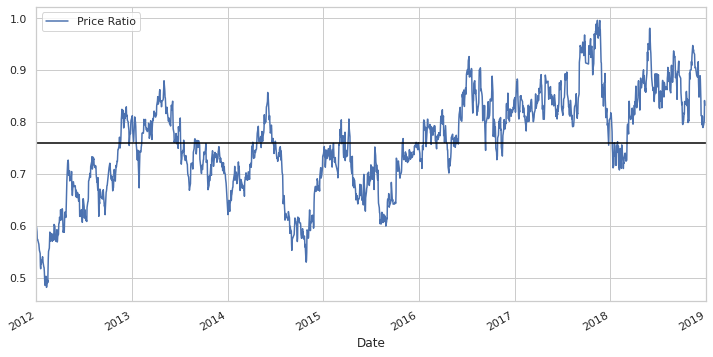

In [25]:
# Price ratio를 그리기
ratio = pair1.삼성전자 / pair1.KB금융
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2012-01-01', '2019-01-01')
plt.legend(['Price Ratio'])

In [26]:
# ADF test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

Critical Value =  -3.559992955927844


## Generate Trading Signals using z-score

In [27]:
# calculate z-score
def zscore(series):
    return (series-series.mean()) / np.std(series)

(734503.0, 737060.0)

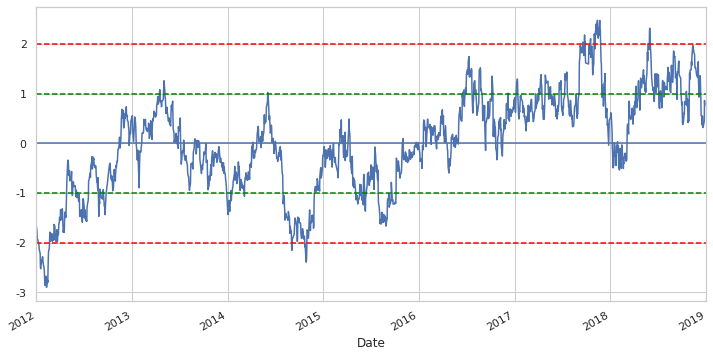

In [28]:
# create a dataframe for trading signals
zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='red', linestyle='--')
plt.xlim('2012-01-01', '2019-01-01')

### Feature Enginerring

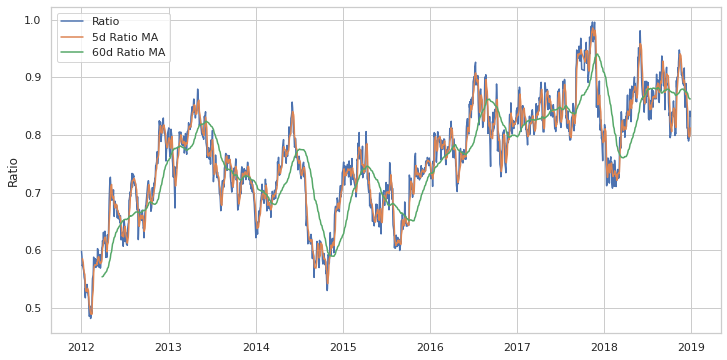

In [29]:
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg60 = ratio.rolling(window=60, center=False).mean()
std_60 = ratio.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

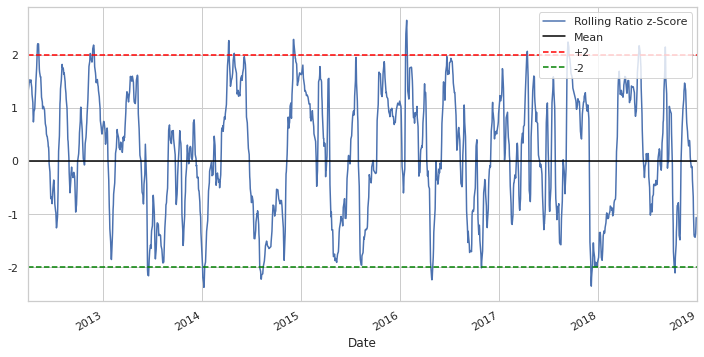

In [30]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2012-03-28', '2019-01-01')
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])
plt.show()

## Creating a Model

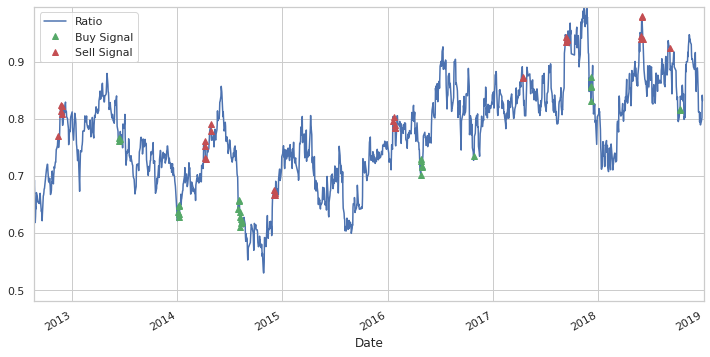

In [31]:
plt.figure(figsize=(12,6))

ratio[160:].plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_60_5>-2] = 0
sell[zscore_60_5<2] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.xlim('2012-08-23','2019-01-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

(734590.0, 737060.0)

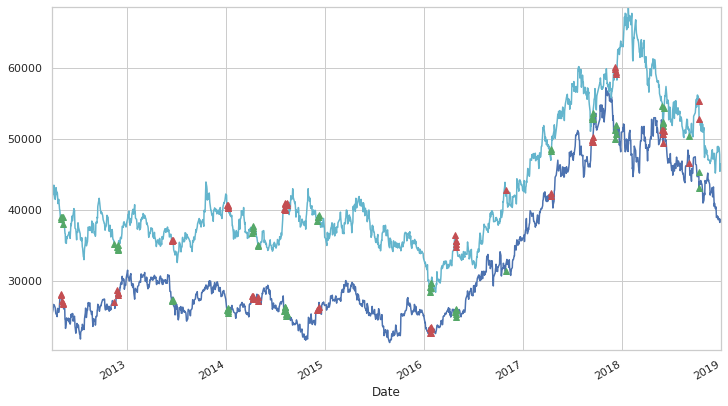

In [32]:
plt.figure(figsize=(12,7))
S1 = train.삼성전자
S2 = train.KB금융

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.xlim('2012-03-28', '2019-01-01')

In [33]:
# Trade using a simple strategy
def trade_print(S1, S2, window1, window2, bound):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    daily_return = []
    for i in range(len(ratios)):
        # Buy long if the z-score is < -bound
        if zscore[i] < -abs(bound):
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print(ratios.index[i])
            print('Buying Ratio %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
        # Sell short if the z-score is > bound
        elif zscore[i] > abs(bound):
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            print(ratios.index[i])
            print('Selling Ratio %s %s %s %s'%(round(money,2),round(ratios[i],2), round(countS1,1),round(countS2,1)))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += S1[i] * countS1 + S2[i] * countS2
            if countS1 * countS2 != 0:
                print(ratios.index[i])
                print('Exit pos %s %s %s %s'%(round(money,2),round(ratios[i],2), 0,0))
            countS1 = 0
            countS2 = 0
        daily_return.append(money)
        
    daily_return = pd.DataFrame({'money':daily_return}, index=S1.index)             
    return daily_return

In [34]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2, bound):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    daily_return = []
    for i in range(len(ratios)):
        # Buy long if the z-score is > bound
        if zscore[i] < -abs(bound):
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print(ratios.index[i])
            #print('Buying Ratio %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
        # Sell short if the z-score is < -bound
        elif zscore[i] > abs(bound):
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print(ratios.index[i])
            #print('Selling Ratio %s %s %s %s'%(round(money,2),round(ratios[i],2), round(countS1,1),round(countS2,1)))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
        daily_return.append(money)
        
    daily_return = pd.DataFrame({'money':daily_return}, index=S1.index)             
    return daily_return

In [35]:
return_df = trade_print(S1, S2, 5, 60, 2)

2012-05-02 00:00:00
Selling Ratio 0.0 0.73 -1 0.7
2012-05-03 00:00:00
Selling Ratio 0.0 0.72 -2 1.4
2012-05-04 00:00:00
Selling Ratio 0.0 0.7 -3 2.1
2012-05-07 00:00:00
Selling Ratio 0.0 0.71 -4 2.8
2012-05-08 00:00:00
Selling Ratio 0.0 0.69 -5 3.5
2012-06-07 00:00:00
Exit pos 8215.09 0.66 0 0
2012-11-14 00:00:00
Selling Ratio 8215.09 0.77 -1 0.8
2012-11-23 00:00:00
Selling Ratio 8215.09 0.82 -2 1.6
2012-11-26 00:00:00
Selling Ratio 8215.09 0.81 -3 2.4
2012-11-27 00:00:00
Selling Ratio 8215.09 0.81 -4 3.2
2012-11-28 00:00:00
Selling Ratio 8215.09 0.82 -5 4.0
2013-01-08 00:00:00
Exit pos 14775.47 0.77 0 0
2013-06-13 00:00:00
Buying Ratio 14775.47 0.76 1 -0.76
2013-06-14 00:00:00
Buying Ratio 14775.47 0.77 2 -1.53
2013-06-17 00:00:00
Buying Ratio 14775.47 0.76 3 -2.29
2013-08-27 00:00:00
Exit pos 14078.1 0.76 0 0
2014-01-03 00:00:00
Buying Ratio 14078.1 0.64 1 -0.64
2014-01-06 00:00:00
Buying Ratio 14078.1 0.65 2 -1.29
2014-01-07 00:00:00
Buying Ratio 14078.1 0.65 3 -1.93
2014-01-08 00:0

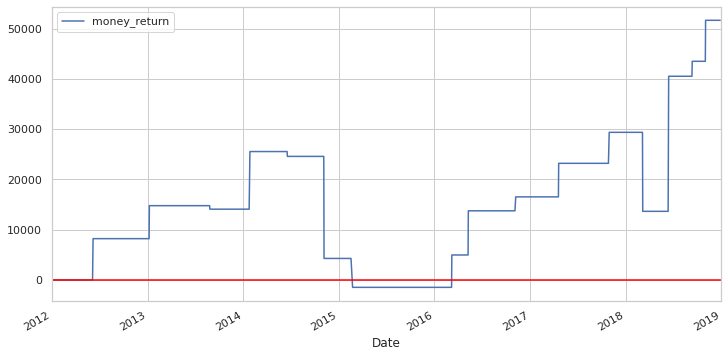

In [36]:
return_df.plot(figsize=(12,6))
plt.axhline(0, color='red')
plt.xlim('2012-01-01', '2019-01-01')
plt.legend(['money_return'])

### Portfolio(All pairs)

In [37]:
def pair_portfolio_return(pair_list, window1, window2, bound, train_set=True):
    if train_set:
        total_return = []
        for pair in pair_list:
            S1 = train[pair[0]]
            S2 = train[pair[1]]
            pair_return = trade(S1, S2, window1, window2, bound)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = S1.index
    else:
        total_return = []
        for pair in pair_list:
            S1 = test[pair[0]]
            S2 = test[pair[1]]
            pair_return = trade(S1, S2, window1, window2, bound)
            total_return.append(pair_return)
        total_return = pd.DataFrame(np.array(total_return).squeeze().T).sum(axis=1)
        total_return.index = S1.index
    return total_return

In [38]:
total_df = pair_portfolio_return(pairs, 5,60,2)

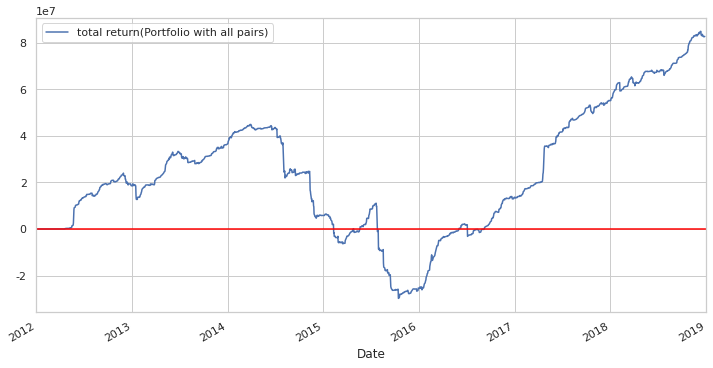

In [39]:
total_df.plot(figsize=(12,6))
plt.axhline(0, color='red')
plt.xlim('2012-01-01', '2019-01-01')
plt.legend(['total return(Portfolio with all pairs)'])

## Backtest(Out of sample)

### Backtest(2019~2021)

In [40]:
S1 = test.삼성전자
S2 = test.KB금융
return_df = trade_print(S1, S2, 5, 60, 2)

2019-05-10 00:00:00
Buying Ratio 0.0 0.93 1 -0.93
2019-05-13 00:00:00
Buying Ratio 0.0 0.92 2 -1.85
2019-05-14 00:00:00
Buying Ratio 0.0 0.92 3 -2.77
2019-05-15 00:00:00
Buying Ratio 0.0 0.92 4 -3.7
2019-05-16 00:00:00
Buying Ratio 0.0 0.9 5 -4.6
2019-05-17 00:00:00
Buying Ratio 0.0 0.9 6 -5.5
2019-05-20 00:00:00
Buying Ratio 0.0 0.91 7 -6.4
2019-06-05 00:00:00
Exit pos 22603.86 0.99 0 0
2020-07-31 00:00:00
Selling Ratio 22603.86 1.64 -1 1.6
2020-08-03 00:00:00
Selling Ratio 22603.86 1.61 -2 3.3
2020-08-04 00:00:00
Selling Ratio 22603.86 1.61 -3 4.9
2020-08-12 00:00:00
Exit pos 42027.07 1.46 0 0
2020-12-29 00:00:00
Selling Ratio 42027.07 1.8 -1 1.8
2020-12-30 00:00:00
Selling Ratio 42027.07 1.87 -2 3.7


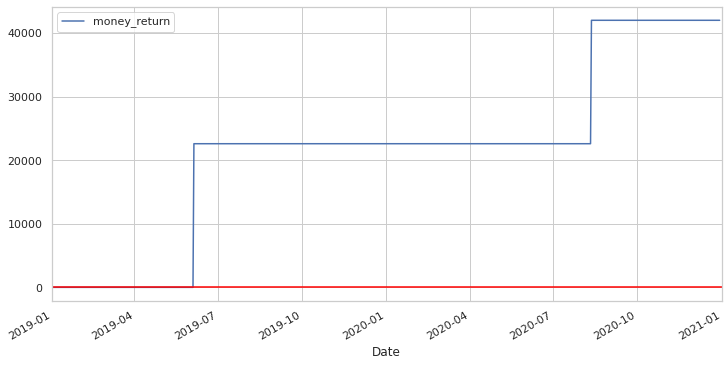

In [41]:
return_df.plot(figsize=(12,6))
plt.axhline(0, color='red')
plt.xlim('2019-01-01', '2021-01-01')
plt.legend(['money_return'])

(737060.0, 737791.0)

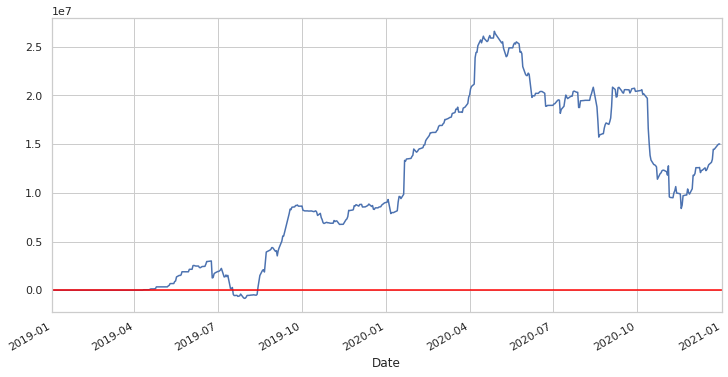

In [42]:
total_df = pair_portfolio_return(pairs, 5,60,2, train_set=False)

total_df.plot(figsize=(12,6))
plt.axhline(0, color='red')
plt.xlim('2019-01-01', '2021-01-01')